In [1]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *

In [2]:
key =  os.environ.get('AZURE_SEARCH_KEY', '5dc2901e41bb45a9a0649837a7016b08')

In [7]:
results = search_images_bing(key, 'happy human face')
ims = results.attrgot('contentUrl')
ims

(#150) ['https://s-media-cache-ak0.pinimg.com/originals/37/8f/fa/378ffa7b4bc07f190ee35f85ed816377.jpg','https://s-media-cache-ak0.pinimg.com/originals/75/92/cb/7592cb6e43184cf95917c751e3f3a170.jpg','https://s-media-cache-ak0.pinimg.com/originals/08/15/db/0815db06df850e27e74411a3232ffa3e.jpg','https://api.time.com/wp-content/uploads/2014/03/happily-surprised.jpg','https://www.happierhuman.com/wp-content/uploads/2018/10/how-to-be-happy.jpg','http://ggia.berkeley.edu/assets/general/GGIA-HumanFace.jpg','http://www.personalenrichmentcenter.com/wp-content/uploads/2016/01/Happy-Human.jpg','https://farm3.static.flickr.com/2226/2140577195_61d14b7dc3.jpg','https://cdn.pixabay.com/photo/2015/10/26/21/58/boy-1007979_960_720.jpg','https://i.pinimg.com/originals/bf/4c/78/bf4c78396b66e528953f21106c6d5d10.jpg'...]

In [4]:
dest = 'images/happy.jpg'
download_url(ims[0], dest)

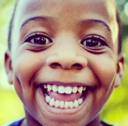

In [6]:
img = Image.open(dest)
img.to_thumb(128)

In [8]:
emotions = 'happy', 'sad'
path = Path('emotion')

In [9]:
if not path.exists():
    path.mkdir()
    for i in emotions:
        dest = (path/i)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{i} human face')
        download_images(dest, urls= results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#279) [Path('emotion/happy/00000000.jpg'),Path('emotion/happy/00000001.jpg'),Path('emotion/happy/00000002.jpg'),Path('emotion/happy/00000003.jpg'),Path('emotion/happy/00000004.jpg'),Path('emotion/happy/00000005.jpg'),Path('emotion/happy/00000006.jpg'),Path('emotion/happy/00000007.jpg'),Path('emotion/happy/00000008.jpg'),Path('emotion/happy/00000009.jpg')...]

In [12]:
failed_img = verify_images(fns)
failed_img

(#2) [Path('emotion/happy/00000046.png'),Path('emotion/sad/00000001.jpg')]

In [13]:
failed_img.map(Path.unlink)

(#2) [None,None]

In [14]:
Emotion = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter= RandomSplitter(valid_pct=0.2, seed=80),
    get_y= parent_label,
    item_tfms= Resize(128)
)

In [15]:
dls = Emotion.dataloaders(path)

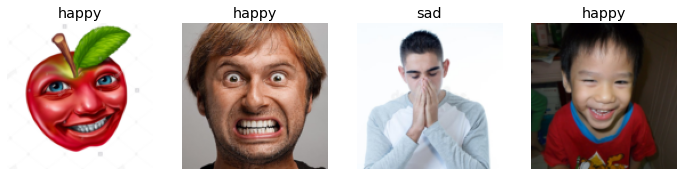

In [16]:
dls.valid.show_batch(max_n=4, nrows= 1)

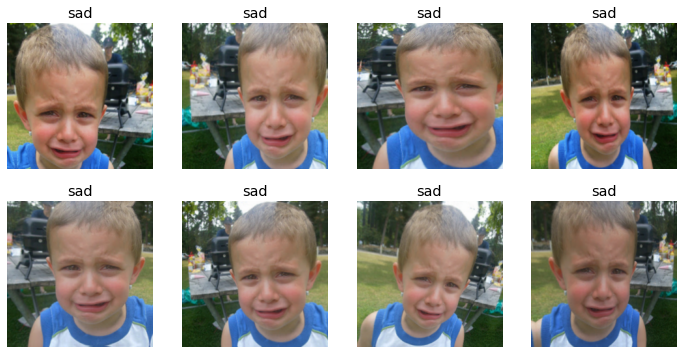

In [19]:
Emotion = Emotion.new(
    item_tfms= RandomResizedCrop(224, min_scale=0.5),
    batch_tfms= aug_transforms()
)
dls = Emotion.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
learn = cnn_learner(dls, resnet18, metrics= error_rate)
learn.fine_tune(6)

epoch     train_loss  valid_loss  error_rate  time    
0         1.353017    1.120316    0.472727    04:58     
epoch     train_loss  valid_loss  error_rate  time    
0         1.133740    0.953125    0.454545    01:23     
1         1.031213    0.948339    0.400000    01:17     
2         0.939898    0.954576    0.363636    01:15     
3         0.862520    0.885443    0.363636    01:20     
4         0.783492    0.852619    0.309091    01:32     
5         0.699917    0.805202    0.272727    01:42     


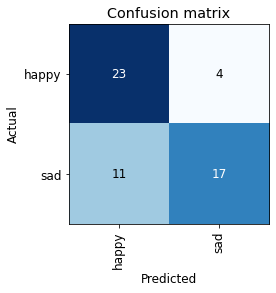

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

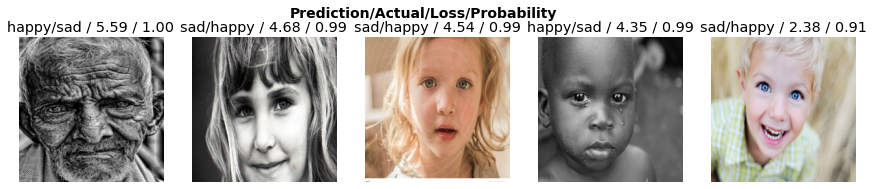

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [27]:
learn.predict('images/happy.jpg')

('happy', tensor(0), tensor([9.9994e-01, 6.4949e-05]))

In [28]:
learn.dls.vocab

['happy', 'sad']

In [29]:
learn.export()

In [34]:
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]